# Stale Alarms By Type

Data was gathered from the alarm inconsistency script.  In the case of CPA, the script was run at 4AM EST, just before a CDI completes, and before any clearing events.
Comparing 5.2.2 and 5.2.1, it seems that the total number of inconsistent alarms is about the same.  That said, the number of stale alarms (present in the system, but missing in VSM) is 0 in 5.2.2, and, thanks to our prior clean-up efforts, reduced to much smaller numbers in 5.2.1.

In [1]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("""
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
<style>.container { width:100% !important; height:100% !important;}</style>
<style>
table {float:left}
</style>

"""))

from stale_alarm_analysis import *

cpa = frame_from_alarm_files(glob.glob("/Users/sean.cavanagh/delete-me/stale-alarms/cpa/*T0*alarm*.csv"),"CPA 5.2.2.1")
sc = frame_from_alarm_files(glob.glob("/Users/sean.cavanagh/delete-me/stale-alarms/sc/*T0*alarmdiffs.csv"),"SC 5.2.2")

cpa['last-processed'] = cpa[['vsm-timestamp','solr-timestamp','datomic-timestamp']].max(axis=1)

all_cpa_pre_sync_alarms = cpa[cpa.date_read > "2017-05-10"]
all_sc_pre_sync_alarms = sc[sc.date_read > "2017-05-10"]




In [2]:
#We have some invalid alarm types that show up 'missing', but aren't
#all_cpa_pre_sync_alarms = all_cpa_pre_sync_alarms[all_sc_pre_sync_alarms.alert_def != 'STATUS_SNMP_LinkDown']
#all_sc_pre_sync_alarms = all_sc_pre_sync_alarms[all_sc_pre_sync_alarms.alert_def != 'STATUS_SNMP_LinkDown']

def fix_recent(df):
    x = pd.Timedelta('20 minutes')
    i = 0
    j = 0
    for index, row in df.iterrows():
        i += 1
        #if i % 10000 == 0: print i, index
        if row['last-processed'] < (row['date_read'] - x):
            if row['category'] == "05 In transit between Tartarus and Heimdallr?":
                j += 1
                df.set_value(index,'category', "03 Stuck between Tartarus and Datomic")
        df.set_value(index,'valid', valid_ebh(row))
    #print j

fix_recent(all_cpa_pre_sync_alarms)
fix_recent(all_sc_pre_sync_alarms)                
                
add_buckets(all_cpa_pre_sync_alarms)
add_buckets(all_sc_pre_sync_alarms)         
            
with open("/Users/sean.cavanagh/delete-me/stale-alarms/cpa/cpa-ids.txt","w") as f: 
    f.write("\n".join(all_cpa_pre_sync_alarms["id"].unique()))
    f.close()

/Users/sean.cavanagh/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/sean.cavanagh/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
stale_alarm_analysis.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [3]:
#Gathered by quering  datomic_athena
real_entities = [l.rstrip() for l in open("/Users/sean.cavanagh/delete-me/stale-alarms/cpa/real-entities.txt","r").readlines()]

cpa_fake_entities = set(all_cpa_pre_sync_alarms['id'].unique()) - set(real_entities)

In [4]:
cpa_pre_sync_alarms = all_cpa_pre_sync_alarms#[~all_cpa_pre_sync_alarms['id'].isin(cpa_fake_entities)]
sc_pre_sync_alarms = all_sc_pre_sync_alarms#[~all_sc_pre_sync_alarms['id'].isin(cpa_fake_entities)]

false_positive_stats = cpa_pre_sync_alarms.valid.value_counts()

cpa_pre_sync_alarms = cpa_pre_sync_alarms[cpa_pre_sync_alarms.valid == "Valid"]
sc_pre_sync_alarms = sc_pre_sync_alarms[sc_pre_sync_alarms.valid == "Valid"]

cpa_pre_sync_alarms = cpa_pre_sync_alarms[cpa_pre_sync_alarms.bucket != "Transient"]
sc_pre_sync_alarms = sc_pre_sync_alarms[sc_pre_sync_alarms.bucket != "Transient"]

cpa_pre_sync_groups = bin_by_field('category',cpa_pre_sync_alarms)
sc_pre_sync_groups  = bin_by_field('category',sc_pre_sync_alarms)

To begin with, 25% of the raw data reflects false positive hits.
The largest category of these are alarms for equipment that is not EBH; routers that don't have the string `-P-` in the name, or MP95 equipment.
Also, the current iteration of the detection script reports mismatches between VSM, Datomic and Solr timestamps.  In many cases this comes from VSM re-sending the same status.  Heimdallr discards those since they have no new information.

These false positives have been removed from the data set for the remainder of this analysis

In [5]:
false_positive_stats

Valid               42343
Not EBH             13211
Discarded Update    10048
Name: valid, dtype: int64

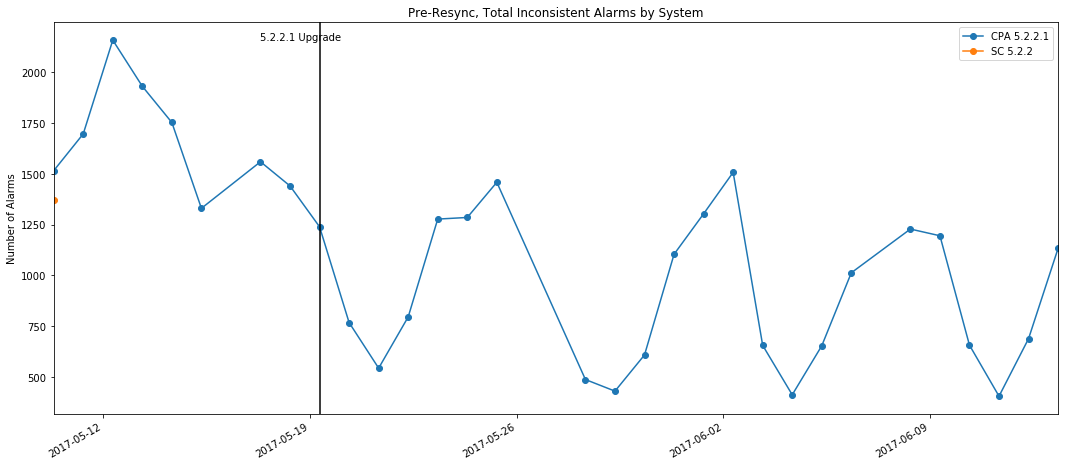

In [6]:
from matplotlib import pyplot,dates
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

pre_sync_totals = bin_by_field('system', [cpa_pre_sync_alarms,sc_pre_sync_alarms])

hfmt = dates.DateFormatter('%m %d')

ax = pre_sync_totals.plot(figsize=(18,8),style='o-', title="Pre-Resync, Total Inconsistent Alarms by System")
ax.set_ylabel("Number of Alarms")
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels)

pyplot.text(pre_sync_totals.index[6],int(max(pre_sync_totals.max())),"5.2.2.1 Upgrade")
pyplot.axvline(x=pre_sync_totals.index[8],color="black")

pyplot.show()


#

We've grouped the alarms in to three states:

| Type | VSM | Exanova
|----|------|-----
| Missing | Present | Absent 
| Inconsistent | Present | Present some places, Absent others 
| Stale | Absent | Present 


Comparing the systems by state, we can see that the inconsistent alarms are about the same, and Santa Clara, 5.2.2, has no stale alarms.

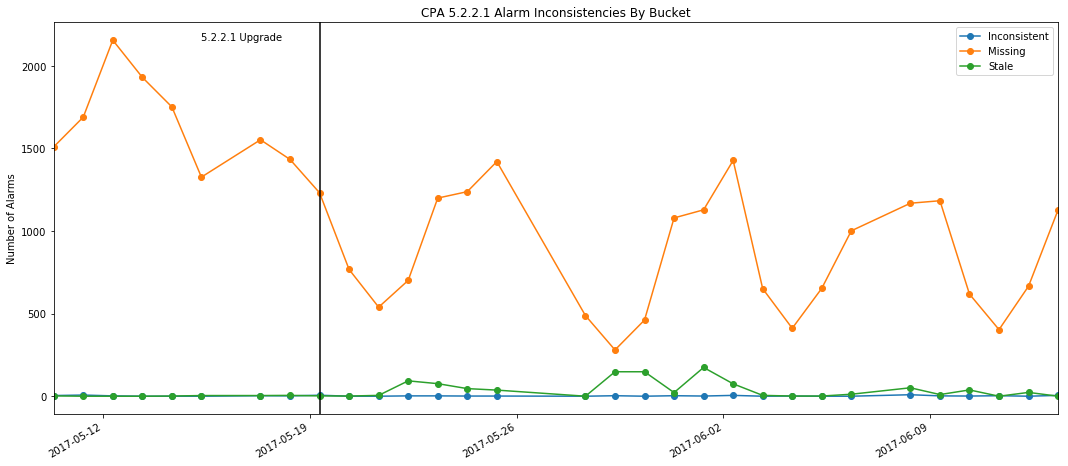

In [7]:
cpa_buckets = bin_by_bucket(cpa_pre_sync_alarms)
ax = cpa_buckets.drop('Transient',1).fillna(0).plot(figsize=(18,8), style="o-", title="CPA 5.2.2.1 Alarm Inconsistencies By Bucket")
ax.set_ylabel("Number of Alarms")
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels)

pyplot.text(pre_sync_totals.index[5],int(max(cpa_buckets.max())),"5.2.2.1 Upgrade")
pyplot.axvline(x=pre_sync_totals.index[8],color="black")

pyplot.show()


/Users/sean.cavanagh/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2903: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=736459.333333, right=736459.333333
  'left=%s, right=%s') % (left, right))


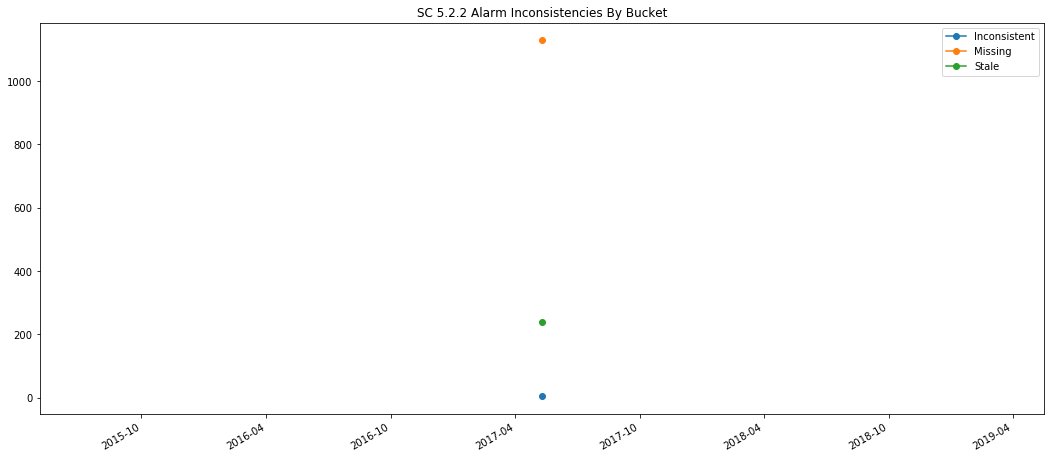

In [8]:
sc_buckets = bin_by_bucket(sc_pre_sync_alarms)
sc_buckets.drop('Transient',1).fillna(0).plot(figsize=(18,8), style="o-", title="SC 5.2.2 Alarm Inconsistencies By Bucket")

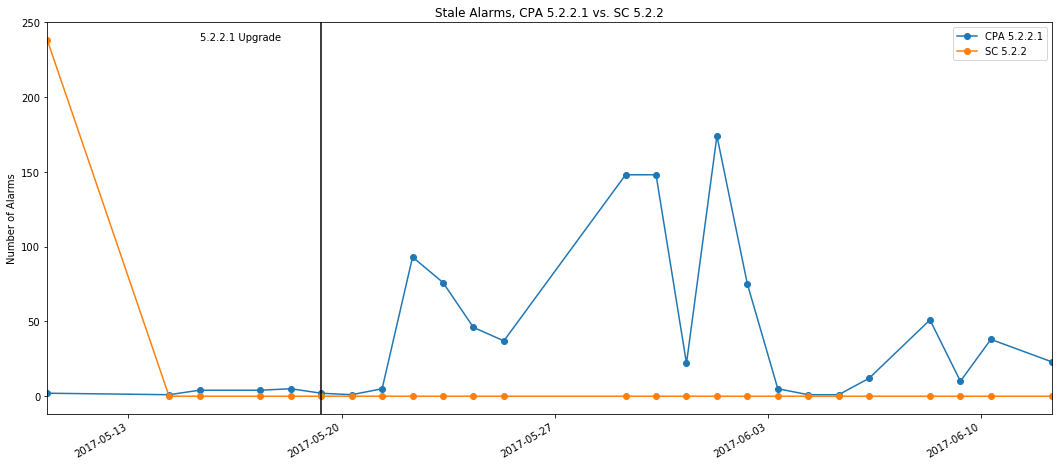

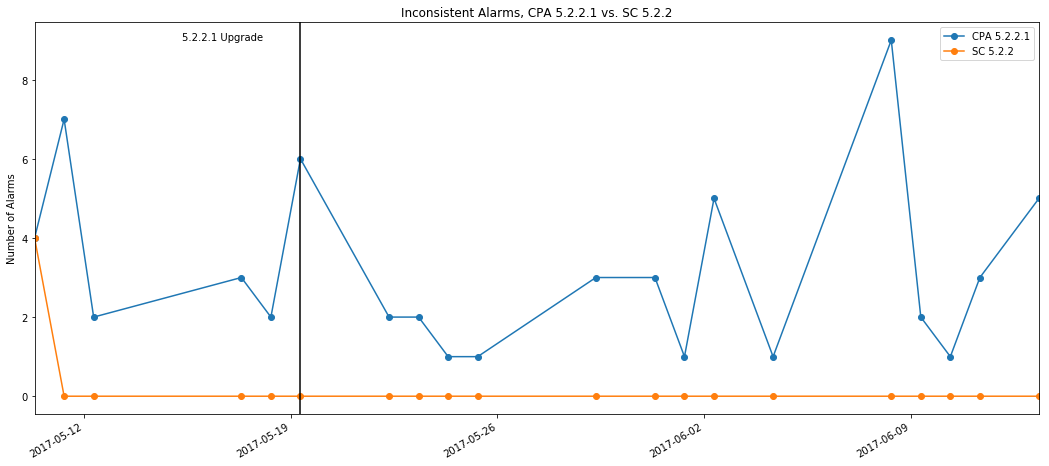

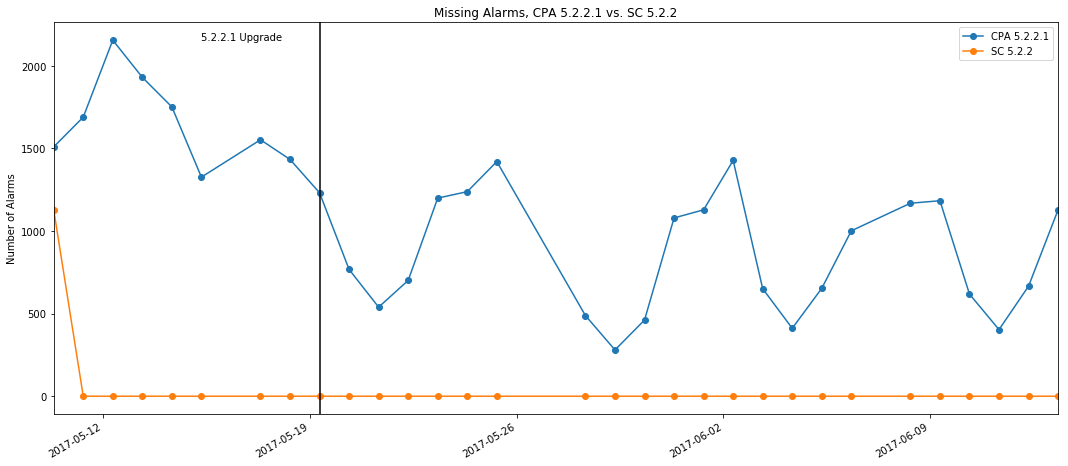

In [9]:
bucket_map = prep_bucket_frames([sc_pre_sync_alarms,cpa_pre_sync_alarms])

for (b,frame) in bucket_map.items():
  try:
    if not b in ['Unclassified','Transient']:
        ax = frame.fillna(0).plot(figsize=(18,8),title="%s Alarms, CPA 5.2.2.1 vs. SC 5.2.2"%b,style="o-")
        ax.set_ylabel("Number of Alarms")
  
        pyplot.text(pre_sync_totals.index[5],max(frame.max()),"5.2.2.1 Upgrade")
        pyplot.axvline(x=pre_sync_totals.index[8],color="black")
  except:
    print b
    raise
pyplot.show()

In [10]:
cpa_pre_sync_alarms["bucket"].value_counts()

Missing         33185
Stale             984
Inconsistent       63
Name: bucket, dtype: int64

In [11]:
cpa_pre_sync_alarms[cpa_pre_sync_alarms.correctable == True]["bucket"].value_counts()

Inconsistent    63
Stale           31
Name: bucket, dtype: int64

In [12]:
cpa_pre_sync_alarms[(cpa_pre_sync_alarms.bucket == "Stale")]["category"].value_counts()

01 Stale (Tartarus -> Heimdallr)          953
01 Stale (Heimdallr -> Solr)               30
02 Partially Stale (Heimdallr -> Solr)      1
Name: category, dtype: int64

In [13]:
cpa_pre_sync_alarms[(cpa_pre_sync_alarms.bucket == "Inconsistent")]["category"].value_counts()

02 Stuck between Heimdallr and Solr    63
Name: category, dtype: int64

In [34]:
cpa_pre_sync_alarms[(cpa_pre_sync_alarms.bucket == "Missing")]["category"].value_counts()

03 Stuck between Tartarus and Heimdallr    22001
08 SOAP request failed                     11039
03 Stuck between Tartarus and Datomic        145
Name: category, dtype: int64

In [14]:
cpa_pre_sync_alarms[cpa_pre_sync_alarms.bucket != "Transient"]["category"].value_counts()

03 Stuck between Tartarus and Heimdallr    22001
08 SOAP request failed                     11039
01 Stale (Tartarus -> Heimdallr)             953
03 Stuck between Tartarus and Datomic        145
02 Stuck between Heimdallr and Solr           63
01 Stale (Heimdallr -> Solr)                  30
02 Partially Stale (Heimdallr -> Solr)         1
Name: category, dtype: int64

Raw data for the stale alarms:

In [15]:
bucket_map["Stale"]

CPA 5.2.2.1  SC 5.2.2
2017-05-10 08:00:00            2     238.0
2017-05-14 08:00:00            1       NaN
2017-05-15 08:00:00            4       NaN
2017-05-17 08:00:00            4       NaN
2017-05-18 08:00:00            5       NaN
2017-05-19 08:00:00            2       NaN
2017-05-20 08:00:00            1       NaN
2017-05-21 08:00:00            5       NaN
2017-05-22 08:00:00           93       NaN
2017-05-23 08:00:00           76       NaN
2017-05-24 08:00:00           46       NaN
2017-05-25 08:00:00           37       NaN
2017-05-29 08:00:00          148       NaN
2017-05-30 08:00:00          148       NaN
2017-05-31 08:00:00           22       NaN
2017-06-01 08:00:00          174       NaN
2017-06-02 08:00:00           75       NaN
2017-06-03 08:00:00            5       NaN
2017-06-04 08:00:00            1       NaN
2017-06-05 08:00:00            1       NaN
2017-06-06 08:00:00           12       NaN
2017-06-08 08:00:00           51       NaN
2017-06-09 08:00:00           10       NaN
2017-06-10 08:00:00           38       NaN
2017-06-12 08:00:00           23       NaN

### Missing Alarms
By far the largest category of alarms are missing.  94.6% of those are missing becuase we do not have an entity in our fault database to match the alarm.  At this time we suspect at least half of those are not of concern to NOC operators, as they affect equipment that is not specific to EBH.  Matthew Ng and I are looking into how to properly identify and filter these.

Another large chunk come from data integrity problems; we failed to build a path, or the SOAP site-id lookup failed.

To put it another way, they aren't in our topology database for three reasons:
1. VSM sent us the right thing, but the network element isn't supported, e.g. routers that aren't cell-site routers 
2. VSM sent us the wrong string
3. A data integrity problem without network prevented us from associating the alarm to the affected entities
  * We failed the path build, so we never generated the topology
  * We failed the SOAP site-id lookup

As the investigation progresses, we've identified root causes for classes of these alarms.  They're broken down below.

At this point there are wide error bars on the Data Inegrity portion.  Preliminary investigation has turned up several problems including the usual Granite Data and router config problems.
We've identitfied strategies for breaking these down further.  Those are to come.

In [16]:
total = (2700000.0 / 10)

In [17]:
missing = cpa_pre_sync_alarms[cpa_pre_sync_alarms.bucket == "Missing"]
(total - len(cpa_pre_sync_alarms)) / total

0.8732148148148148

In [18]:
bad_sites = ["IntrusionSiteIn:SCR WTN PRESIDENTS ISLAND 0263:22989", "IntrusionSiteIn:CASO CIRCLE CITY:6014", "IntrusionSiteIn:CASO BAKE:5868", "IntrusionSiteIn:LSV NORTH LAS VEGAS (NLV):48795", "IntrusionSiteIn:GP GOB:41465", "IntrusionSiteIn:MC HAYES & UTICA/0905 [EBH]:68407", "IntrusionSiteIn:KM LINE CREEK (WORLDSPAN):40554", "IntrusionSiteIn:MC FORD & SCHAEFER/0812 [EBH]:68347", "IntrusionSiteIn:OH NORTH NEWPORT:70365", "IntrusionSiteIn:KM SHAWNEE PD:40624", "IntrusionSiteIn:KM SHAMROCK:29469", "IntrusionSiteIn:MW LOOMIS RD. WEPCO* (141009):14769", "IntrusionSiteIn:PHO MAXJO:62849", "IntrusionSiteIn:MC CLARKSTON WEST / 0190 [EBH]:68125", "IntrusionSiteIn:CASO RIALTO:6624", "IntrusionSiteIn:OH I71 & 561:69400", "IntrusionSiteIn:OH GEORGETOWN:69968", "IntrusionSiteIn:CASO INDUS:8471", "IntrusionSiteIn:KM MAPLE LEAF:29472", "IntrusionSiteIn:MC I-75 & VANHORN / 1149 [EBH]:153110", "IntrusionSiteIn:NW FAIRFIELD CT:75205", "IntrusionSiteIn:KM SOUTH JEFFERSON CITY:29131", "IntrusionSiteIn:LSV GAYLORD:48743", "IntrusionSiteIn:CASO DUPONT:6097", "IntrusionSiteIn:CASO STEVENSONS PK:7027", "IntrusionSiteIn:OH HYDE PARK:69522", "IntrusionSiteIn:IN WASHINGTON STREET WEST:170353", "IntrusionSiteIn:OH NORTH WORTHINGTON:69645", "IntrusionSiteIn:OH WEST DAYTON:69520", "IntrusionSiteIn:IN AVON:169130", "IntrusionSiteIn:CASO LAKE FOREST:6340", "IntrusionSiteIn:PHO MARIPOSA:60909", "IntrusionSiteIn:OH RIDGEWOOD:149680", "IntrusionSiteIn:LSV KIOWA:49092", "IntrusionSiteIn:CASO HAMPTON:98877", "IntrusionSiteIn:PHO CAPITOL:61022", "IntrusionSiteIn:CH CAROL STREAM:13925", "IntrusionSiteIn:PHO CUCHILLO:111979", "IntrusionSiteIn:MC SOUTHFIELD & I75 / 0875 [EBH]:68387", "IntrusionSiteIn:IN CARMEL CITY:50772", "IntrusionSiteIn:CASO ALLEN:8143", "IntrusionSiteIn:PHO GREENWAY:60956", "IntrusionSiteIn:CASO STUDIO CITY:6761", "IntrusionSiteIn:PHO QUEEN CREEK:60899", "IntrusionSiteIn:KM DERBY:40493", "IntrusionSiteIn:CASO RANCHO MARG:6609", "IntrusionSiteIn:PHO SKY HARBOR:60779", "IntrusionSiteIn:OH SOUTH KETTERING:69525", "IntrusionSiteIn:OH GRANDVIEW:69843", "IntrusionSiteIn:CASO MCFADDEN:6427", "IntrusionSiteIn:LSV TIBERTI:48851", "IntrusionSiteIn:PHO BELL ROAD:60957", "IntrusionSiteIn:OH BETHEL:70158", "IntrusionSiteIn:CASO CADIZ:5950", "IntrusionSiteIn:MC BIG BEAVER AIRPORT/0169 [EBH]:68105", "IntrusionSiteIn:SCR TUL FLORENCE STREET 432:11218", "IntrusionSiteIn:CASO ALAMITAS:9012", "IntrusionSiteIn:PHO ICE RINK:111383", "IntrusionSiteIn:IN PLUM CREEK:50924", "IntrusionSiteIn:LSV SCOTLAND:48962", "IntrusionSiteIn:KM CONTINENTAL:40488", "IntrusionSiteIn:KM KANSAS CITY KS:40695", "IntrusionSiteIn:GC 4160-229129-CONSTITUTION [ALLTEL]:105899", "IntrusionSiteIn:OH WEST UNION:69806", "IntrusionSiteIn:CASO WESTLAKE:6887", "IntrusionSiteIn:KM CAPTAIN HOOK:84262", "IntrusionSiteIn:IN VALLEY MILLS:50969", "IntrusionSiteIn:LSV WASHINGTON/DECATUR:48861", "IntrusionSiteIn:OH YANKEE:70328", "IntrusionSiteIn:PHO MICHELANGELO:62873", "IntrusionSiteIn:MC SOUTHFIELD/0040 [EBH]:67985", "IntrusionSiteIn:SCR TUL OKMULGEE EXPRESSWAY 401:152632", "IntrusionSiteIn:GP URBANDALE:41457", "IntrusionSiteIn:CASO DESILU:6072", "IntrusionSiteIn:PHO VOLTAIRE:63152", "IntrusionSiteIn:LSV SUNSET/ I-15:48841", "IntrusionSiteIn:KM LITTLE ARKANSAS:143609", "IntrusionSiteIn:KM ADAMS DAIRY:99833", "IntrusionSiteIn:LSV TAMARUS:49128", "IntrusionSiteIn:MC UTICA/0159 [EBH]:68095", "IntrusionSiteIn:OH WHITE OAK:164071", "IntrusionSiteIn:NW RIVERBANK:75257", "IntrusionSiteIn:CASO ARMSTRONG:102590", "IntrusionSiteIn:CASO REAGAN:83189", "IntrusionSiteIn:MW DOUGLAS CELLONE (140764):14736", "IntrusionSiteIn:GC 4160-136130-HAPPY SITE:47045", "IntrusionSiteIn:SCR TUL READING PLACE OK 448:135800", "IntrusionSiteIn:DA 4119-7-1-133057-VALWOOD [CR37]:9366", "IntrusionSiteIn:CASO OXEN CORNER:6547", "IntrusionSiteIn:CASO SAN PASQUAL:6679", "IntrusionSiteIn:MC HEYDENREICH / 0832 [EBH]:68362", "IntrusionSiteIn:OH WPAFB:96506", "IntrusionSiteIn:CASO HUNTER:8723", "IntrusionSiteIn:CASO MESA VERDE:6432", "IntrusionSiteIn:OH ORANGE PLACE:69399", "IntrusionSiteIn:PHO 43RD & OLIVE (AKA 43RD AVE & DUNLAP):111822", "IntrusionSiteIn:PH SOUDERTON:91187", "IntrusionSiteIn:CASO AGAPE:8501", "IntrusionSiteIn:GP MIN JON:167214", "IntrusionSiteIn:PHO UTOPIA:60958", "IntrusionSiteIn:UP MIDLER:80668", "IntrusionSiteIn:CANO HWY 80 VACAVILLE:65158", "IntrusionSiteIn:CASO CARLSBAD:7133", "IntrusionSiteIn:ID5 WENDELL:53953", "IntrusionSiteIn:OH POLARIS II:69727", "IntrusionSiteIn:GP N CEDAR RAPIDS:41513", "IntrusionSiteIn:OH SYMMES TOWNSHIP:69608", "IntrusionSiteIn:PHO HOWARD:61018", "IntrusionSiteIn:AP EVERETT ST:119767", "IntrusionSiteIn:ID5 RAIL:111211", "IntrusionSiteIn:GP BENNINGTON_AM:108379", "IntrusionSiteIn:PHO 16TH ST & CACTUS:111853", "IntrusionSiteIn:CASO RIVERSIDE MUNC:7966", "IntrusionSiteIn:CASO JERONIMO:6291", "IntrusionSiteIn:TUC GRANT & I-10 [ALLTEL]:111940", "IntrusionSiteIn:OH WARRENSVILLE:69474", "IntrusionSiteIn:CASO CHINATOWN:6007", "IntrusionSiteIn:PHO RURAL:111697", "IntrusionSiteIn:LSV SPANISH TRAILS:48831", "IntrusionSiteIn:PHO FRITO:61030", "IntrusionSiteIn:CASO EAGLE ROCK:6100", "IntrusionSiteIn:CASO LIMONITE:7885", "IntrusionSiteIn:GP EAST VILLAGE:165148", "IntrusionSiteIn:OH FELICITY:69469", "IntrusionSiteIn:CASO 4 LEVEL:5800", "IntrusionSiteIn:LSV LOSEE ROAD:48770", "IntrusionSiteIn:IN WANAMAKER:50971", "IntrusionSiteIn:GC 4160-230833-PALAFOX [ALLTEL]:105705", "IntrusionSiteIn:PHO DOWNTOWN SCOTTSDALE STADIUM:111794", "IntrusionSiteIn:CASO GLASSELL:6176", "IntrusionSiteIn:PHO WIGWAM:62959", "IntrusionSiteIn:OH FOREST PARK:69699", "IntrusionSiteIn:OH NEW LEBANON:69912", "IntrusionSiteIn:LSV SIENNA:49031", "IntrusionSiteIn:CH BLOOMINGDALE II:13560", "IntrusionSiteIn:CASO EMERALD BAY:6121", "IntrusionSiteIn:OH HAMILTON & I 270:69638", "IntrusionSiteIn:CASO LAUREL:102896", "IntrusionSiteIn:ILWI MW KENOSHA NORTH:133991", "IntrusionSiteIn:OH RED LION:70960", "IntrusionSiteIn:PHO ARROWHEAD:61007", "IntrusionSiteIn:PHO FASHION SQUARE:60804", "IntrusionSiteIn:MW 7 MILE RD WEPCO (140760):14733", "IntrusionSiteIn:PHO GREENLEAF:82996", "IntrusionSiteIn:SCR TUL BROKEN ARROW FIRE STATION 426:11180", "IntrusionSiteIn:OH ERLANGER:69570", "IntrusionSiteIn:PHO INED:61021", "IntrusionSiteIn:PHO JERSEY:64580", "IntrusionSiteIn:SCR TUL VERDIGRIS 547:10998", "IntrusionSiteIn:MC DEQUINDRE & 18 MILE / 0885 [EBH]:68396", "IntrusionSiteIn:CASO RANCHO TRABUCO:7647", "IntrusionSiteIn:PHO ESPLANADE:60827", "IntrusionSiteIn:KM LINCOLN CEMETERY:40553", "IntrusionSiteIn:SCR WTN CORDOVA 0511:23642", "IntrusionSiteIn:PHO ASHLAND RANCH:62112", "IntrusionSiteIn:OH WORTHINGTON:69887", "IntrusionSiteIn:TUC 6TH & 44TH STREET:111671", "IntrusionSiteIn:OH SOUTH BEAVERCREEK:69612", "IntrusionSiteIn:MW COFRIN LIBRARY (142110):14843", "IntrusionSiteIn:CANO SMILEY TOWER:65272", "IntrusionSiteIn:CASO GRAVEL PITS:6194", "IntrusionSiteIn:PHO HONEY:60815", "IntrusionSiteIn:PHO RIVERVIEW:60856", "IntrusionSiteIn:KM US 63:29449", "IntrusionSiteIn:SCR TUL TISDALE EXPRESSWAY 563:10986", "IntrusionSiteIn:OH PAUL BROWN STADIUM:165857", "IntrusionSiteIn:OH ROCKSIDE & I271:70964", "IntrusionSiteIn:KM SUGAR CREEK:40640", "IntrusionSiteIn:PHO MCNAIR:112054", "IntrusionSiteIn:MC MADISON HEIGHTS/0061 [EBH]:68005", "IntrusionSiteIn:KM GODDARD:40954", "IntrusionSiteIn:OH BRADYSVILLE:88725", "IntrusionSiteIn:OH OSU HOSPITALS:70612", "IntrusionSiteIn:OH HAYDEN RUN:70120", "IntrusionSiteIn:PHO DRAGON:61005", "IntrusionSiteIn:NW STRATFORD SOUTH:75229", "IntrusionSiteIn:LSV RHODES RANCH:48894", "IntrusionSiteIn:PHO RIGGS & MOUER:160529", "IntrusionSiteIn:GP RADCLIFFE:107940", "IntrusionSiteIn:MW OAK CREEK CITY HALL (FD) (145017):15054", "IntrusionSiteIn:TUC MAGEE & ORACLE:111692", "IntrusionSiteIn:LSV WET N WILD:48921", "IntrusionSiteIn:PHO TOWN LAKE:111800", "IntrusionSiteIn:CASO TEMPLE CITY RELO:143090", "IntrusionSiteIn:OH MONTANA & I74:69923", "IntrusionSiteIn:OH COLERAIN TOWNSHIP:69693", "IntrusionSiteIn:PHO LITCHFIELD PARK:60785", "IntrusionSiteIn:GP VERNON:42017", "IntrusionSiteIn:OH BROOKSIDE PARK:69783", "IntrusionSiteIn:PHO WREN:60833", "IntrusionSiteIn:GP WEST O:107868", "IntrusionSiteIn:OH MOUNT HOPE:69703", "IntrusionSiteIn:NE CLINTON_MA:73295", "IntrusionSiteIn:KM GILHAM ROAD:135600", "IntrusionSiteIn:CASO GLEN EDEN:7667", "IntrusionSiteIn:MW MARCY WEPCO (141005):14927", "IntrusionSiteIn:PHO BUGSY:60850", "IntrusionSiteIn:CANO NEW HALL:65212", "IntrusionSiteIn:PHO CHANDLER:61009", "IntrusionSiteIn:CASO LA BREA:6311", "IntrusionSiteIn:OH BETHEL TOWNSHIP:69661", "IntrusionSiteIn:PHO MONTE:60892", "IntrusionSiteIn:MC LODGE & I75/0930 [EBH]:68426", "IntrusionSiteIn:CASO MAIN:6396", "IntrusionSiteIn:PHO NORTONS CORNER:62116", "IntrusionSiteIn:PHO 48TH ST:60853", "IntrusionSiteIn:CASO LA CONV CTR:6314", "IntrusionSiteIn:MC BELLEVILLE/0153 [EBH]:68089", "IntrusionSiteIn:CASO DNTN LA:6082", "IntrusionSiteIn:TUC LAMBERT:61818", "IntrusionSiteIn:PHO PIMA PARK:60778", "IntrusionSiteIn:ID5 GOODING:53918", "IntrusionSiteIn:PHO LAKES:60905", "IntrusionSiteIn:CANO 7TH & HARRISON:65635", "IntrusionSiteIn:LSV SMOKE RANCH:48824", "IntrusionSiteIn:CASO BEAR VIEW:8771", "IntrusionSiteIn:MW WCTC (140815):14756", "IntrusionSiteIn:SCR WTN MED CENTER 0592:23721", "IntrusionSiteIn:SCR WTN PEABODY PARK 0254:23142", "IntrusionSiteIn:LSV HOLLYWOOD:48755", "IntrusionSiteIn:OH FLORENCE:69708", "IntrusionSiteIn:CASO HOTEL HOLLYWOOD:6250", "IntrusionSiteIn:CASO N GLENDALE:6480", "IntrusionSiteIn:NE WESTMINSTER_MA:85196", "IntrusionSiteIn:CASO VIA MANOLETTE:85744", "IntrusionSiteIn:OH ANDERSON TOWNSHIP:69677", "IntrusionSiteIn:CASO PERRIS:6574", "IntrusionSiteIn:CASO MISSION V HOSP:6447", "IntrusionSiteIn:PHO COVEY:111448", "IntrusionSiteIn:CH HARVEY:13203", "IntrusionSiteIn:CASO RED LION RELO:6617", "IntrusionSiteIn:OH SUGARCREEK:69527", "IntrusionSiteIn:TUC SHILOH:62217", "IntrusionSiteIn:OH BROOKPARK:69757", "IntrusionSiteIn:PHO MELODY LANE:60936", "IntrusionSiteIn:PHO 43RD AVE & THOMAS:111663", "IntrusionSiteIn:MC ALLEN PARK/0150 [EBH]:68086", "IntrusionSiteIn:LSV SPEEDWAY:48832", "IntrusionSiteIn:SCR TUL TULSA SOUTHEAST 548:11085", "IntrusionSiteIn:CH RTE 25 & ST CHARLES:90080", "IntrusionSiteIn:NW WESTPORT 2:75137", "IntrusionSiteIn:CASO ALTADENA:5828", "IntrusionSiteIn:OH POLARIS:69859", "IntrusionSiteIn:MC CHUBB & 8 MILE / 0151 [EBH]:68087", "IntrusionSiteIn:MC WALTON & CROOKS / 0860 [EBH]:68381", "IntrusionSiteIn:PHO DES:88524", "IntrusionSiteIn:DA 4119-7-2-132706-LAS_VEGAS [HUB DWDM CR25]:9226", "IntrusionSiteIn:OH RIVERSIDE HOSPITAL:69632", "IntrusionSiteIn:MW PACKERLAND (142105):14839", "IntrusionSiteIn:SCR TUL SAND SPRINGS NORTH 457:10976", "IntrusionSiteIn:UP COMFORT HILL:80467", "IntrusionSiteIn:PHO GUADALUPE & HAWES:112062", "IntrusionSiteIn:OH OSU:69795", "IntrusionSiteIn:CH WHEATON NORTH:13745", "IntrusionSiteIn:PHO BOULDERS:60768", "IntrusionSiteIn:MW KK AVE-TOWER SITES (145021):15012", "IntrusionSiteIn:SCR TUL TURLEY NORTH 491:82845", "IntrusionSiteIn:PHO UNION HILLS:60891", "IntrusionSiteIn:OH NEWPORT:69484", "IntrusionSiteIn:CASO SASSY:8066", "IntrusionSiteIn:OH MOUNT ADAMS:69634", "IntrusionSiteIn:OH MOUNT AIRY:69704", "IntrusionSiteIn:CASO CROWNVIEW:8598", "IntrusionSiteIn:KM LENEXA:40551", "IntrusionSiteIn:SCR WTN AMERICAN WAY 089:157453", "IntrusionSiteIn:SCR WTN AIRWAYS RAINES 0105:23707", "IntrusionSiteIn:KM I435 & FRONT STREET:40530", "IntrusionSiteIn:OH OSU CENTRAL CAMPUS:69796", "IntrusionSiteIn:OH PARMA HEIGHTS [ALLTEL]:118219", "IntrusionSiteIn:LSV VILLAGE VIEW:49080", "IntrusionSiteIn:KM 23RD & CRYSLER:40458", "IntrusionSiteIn:OH I75 & KEOWEE:69497", "IntrusionSiteIn:MC BIRMINGHAM/0035 [EBH]:67980", "IntrusionSiteIn:CASO ATWATER:5859", "IntrusionSiteIn:WASP-LA GRANDE MTN:93163", "IntrusionSiteIn:CASO PENSKE:26923", "IntrusionSiteIn:ID5 SHOSHONE:53925", "IntrusionSiteIn:PHO BANFF:62185", "IntrusionSiteIn:PHO COOPER:60914", "IntrusionSiteIn:MC ROTUNDA DRIVE/0166 [EBH]:68102", "IntrusionSiteIn:MC M59 & TELEGRAPH / 0831 [EBH]:68361", "IntrusionSiteIn:CASO FAIRGROUNDS:7210", "IntrusionSiteIn:CASO PRINCESSA:123346", "IntrusionSiteIn:CASO LOS ALAMOS:7984", "IntrusionSiteIn:MW NEW MUNSTER USC (143821):15104", "IntrusionSiteIn:PHO TENEDOR:112033", "IntrusionSiteIn:CH LAKE AND GARY:14547", "IntrusionSiteIn:TUC KINNEY:61843", "IntrusionSiteIn:KM RAILYARD:40604", "IntrusionSiteIn:SCR WTN RIVERFRONT 0264:23605", "IntrusionSiteIn:PHO PALM VALLEY:63149", "IntrusionSiteIn:OH WITHAMSVILLE:69424", "IntrusionSiteIn:LSV W FLAMINGO (DECATUR & FLAMINGO):48864", "IntrusionSiteIn:NW SPRINGFIELD NORTH WEST [BIRNIE AVE]:75385", "IntrusionSiteIn:KM BLACKBOB:40474", "IntrusionSiteIn:OH DAYTON MALL:69573", "IntrusionSiteIn:PHO ASU:60817", "IntrusionSiteIn:CASO LOS ROBLES:6381", "IntrusionSiteIn:PHO SLUGGO:60897", "IntrusionSiteIn:KM OAKWOOD MANOR:93259", "IntrusionSiteIn:CASO RED HILL:6614", "IntrusionSiteIn:CASO GREENWAY:6201", "IntrusionSiteIn:OH SHAFOR:70983", "IntrusionSiteIn:CASO BEAR CREEK:8021", "IntrusionSiteIn:IN BALL MEMORIAL HOSPITAL:88015", "IntrusionSiteIn:LSV STARR:49096", "IntrusionSiteIn:CASO MARYGOLD:8448", "IntrusionSiteIn:NW HAMDEN 2:75510", "IntrusionSiteIn:AP TRI-COUNTY ICE ARENA:120077", "IntrusionSiteIn:CASO RISING SUN:8704", "IntrusionSiteIn:CASO RANCHO CAL RD:7975", "IntrusionSiteIn:PHO 51ST AVENUE:60975", "IntrusionSiteIn:NW BRUCE GOLF:75204", "IntrusionSiteIn:ILWI MW MITCHELL DAS:154016", "IntrusionSiteIn:CANO BEKINS [SF 1B]:64748", "IntrusionSiteIn:FL ORLHFL01-000237-CROWN HERNDON:46474", "IntrusionSiteIn:OH BURNS:128865", "IntrusionSiteIn:KM EASTLAND DRIVE:29451", "IntrusionSiteIn:SCR TUL GARY AVENUE SOUTH 506:11200", "IntrusionSiteIn:CASO DEL MAR OC:6067", "IntrusionSiteIn:CH PALOS HEIGHTS:13126", "IntrusionSiteIn:CASO BONNIE:95889", "IntrusionSiteIn:OH DAYTON AIRPORT:70399", "IntrusionSiteIn:GP ISLE:92850", "IntrusionSiteIn:MW GRAY CT. CELLCOM (142106):14840", "IntrusionSiteIn:OH FOREST PARK EAST:69590", "IntrusionSiteIn:CASO DOWNTOWN SD:7192", "IntrusionSiteIn:MC AUBURN HILLS/0038 [EBH]:67983", "IntrusionSiteIn:LSV BUFFALO:48702", "IntrusionSiteIn:CASO CARR:5976", "IntrusionSiteIn:CH CHICAGO RIDGE:13251", "IntrusionSiteIn:NE WEST ANDOVER 2 RELO_MA:74607", "IntrusionSiteIn:CASO SPECTRUM:6743", "IntrusionSiteIn:MC 8 MILE & BECK/0172 [EBH]:68458", "IntrusionSiteIn:OH CAMDEN:69601", "IntrusionSiteIn:OH WINDMERE:84247", "IntrusionSiteIn:OH BROOKPARK [ALLTEL]:117945", "IntrusionSiteIn:ABQ I-25 OSUNA:111715", "IntrusionSiteIn:OH INDEPENDENCE (KY):70379", "IntrusionSiteIn:MC 17 MILE & UTICA / 1078 [EBH]:84754", "IntrusionSiteIn:SCR WTN MIDTOWN 0510:23641", "IntrusionSiteIn:OH CREW STADIUM:70615", "IntrusionSiteIn:OH SPRINGBORO:69662", "IntrusionSiteIn:PHO ROGERS RANCH:82944", "IntrusionSiteIn:LSV FBI:49072", ]

In [19]:
bad_site_alarms = missing[(missing.alert_def == "IntrusionSiteIn") & (missing.category != "08 SOAP request failed")].copy()
bad_site_alarms["concrete_type"] = bad_site_alarms.id.apply(lambda x: x in bad_sites and ":Cell" or ":CellSite")

In [20]:
total = len(missing)
failed_soap = len(missing[missing.category == "08 SOAP request failed"])
cell_site = len(bad_site_alarms[bad_site_alarms.concrete_type != ":CellSite"])
missing_router = 482
missing_port = 1301
data_integrity = len(missing[(missing.category != "08 SOAP request failed") & missing['id'].isin(cpa_fake_entities)]) - missing_router - missing_port
processed_incorrectly = len(missing[(missing.category != "08 SOAP request failed") & ~missing['id'].isin(cpa_fake_entities)])

stats = {"Total" : total,
         "Failed SOAP" : failed_soap,
         "Intrusion with Mis-labelled Cell Site Category" : cell_site,
         "Path Build (Unknown)" : data_integrity,
         "Path Build (Missing Router)" : missing_router,
         "Path Build (Missing Port)" : missing_port,
         "Unknown" : processed_incorrectly}
missing_categories = pd.Series(data = stats)
missing_categories

Failed SOAP                                       11039
Intrusion with Mis-labelled Cell Site Category      127
Path Build (Missing Port)                          1301
Path Build (Missing Router)                         482
Path Build (Unknown)                              15655
Total                                             33185
Unknown                                            4708
dtype: int64

## Investigation Scratch Pad

In [21]:
cpa_category_counts = pd.DataFrame({'Processed':cpa_pre_sync_alarms[~cpa_pre_sync_alarms['id'].isin(cpa_fake_entities)]['alert_def'].value_counts(),
                                    'Discarded':cpa_pre_sync_alarms[cpa_pre_sync_alarms['id'].isin(cpa_fake_entities)]['alert_def'].value_counts()}).fillna(0)
cpa_category_counts['Total'] = (cpa_category_counts['Discarded'] + cpa_category_counts['Processed'])
cpa_category_counts['Total'] = cpa_category_counts['Total'].apply(lambda  x: int(x))
cpa_category_counts['Processed'] = cpa_category_counts['Processed'].apply(lambda  x: int(x))
x = cpa_category_counts.sum()
processed_ratio =  float(x['Processed'])/x['Total']
print "Total:      {t}\nProcessed:   {p}\nDiscarded:  {d}\nProcessed Ratio: {pr:.2f}%".format(t=x['Total'],p=x['Processed'],d=x['Discarded'],pr=(100*processed_ratio))

Total:      34232
Processed:   5741
Discarded:  28491
Processed Ratio: 16.77%


In [22]:
# N.B.  If, for some subset of alert defs, we grep for router ID's that don't start with [A-Z]+-P then we'll get a bunch of type 1's


foo = cpa_category_counts['Processed'] / (cpa_category_counts['Total'] )
cpa_category_counts['raw_ratio'] = foo
cpa_category_counts['Processed Ratio'] = foo.apply(lambda x:"{0:.0f}%".format(x*100))
cpa_category_counts.sort_values(by=['raw_ratio'], ascending=True).drop(['raw_ratio'],1)


Discarded  Processed  Total Processed Ratio
alarm_ebh-304-4-235             45          0     45              0%
alarm_ebh-3629-4-1414            2          0      2              0%
STATUS_NodeDown_EBH              2          0      2              0%
STATUS_SNMP_LinkDown             2          0      2              0%
alarm_ebh-8-3-6               2785         25   2810              1%
alarm_ebh-305-4-236           1065         17   1082              2%
IntrusionSiteIn              11688        319  12007              3%
omcr88_PBTS                     14          1     15              7%
ntBsmBtsHeartBt                 66          6     72              8%
eossHeartbeatFailure           500         51    551              9%
alarm_ebh-633-3-117            830        127    957             13%
alarm-243                      390         70    460             15%
alarm_ebh-12-4-10             2185        426   2611             16%
omcr78                          13          3     16             19%
alarm_ebh-30-12-23            3115        899   4014             22%
alarm_ebh-439-46-346          2258        704   2962             24%
ECP_AP_RCS_LNKSDWN              45         15     60             25%
ECP_CDM_CELL_OOS                35         12     47             26%
STATUS_NodeDown                 53         19     72             26%
alarm_ebh-438-46-345           379        154    533             29%
alarm-4385                     250        114    364             31%
STATUS_SNMP-P_Link_Down       2330       2067   4397             47%
envDoorIntrusion                18         20     38             53%
CISCO_BFD-syslogMessage        405        664   1069             62%
omcr79                          16         28     44             64%

In [23]:
foo = cpa_pre_sync_alarms[cpa_pre_sync_alarms.alert_def == "CISCO_BFD-syslogMessage"][cpa_pre_sync_alarms.bucket == "Missing"]
foo["in_athena"] = foo["id"].apply(lambda x: x not in cpa_fake_entities)#["id"].value_counts()#apply(lambda x: x[:48])
foo[foo.in_athena == False]
foo["id"].iloc[300]

/Users/sean.cavanagh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


'CISCO_BFD-syslogMessage:MACNGAYQ91A-P-CI-9010-01_172.24.196.197_VLAN_1611'

In [24]:
import re
foo = cpa_pre_sync_alarms[cpa_pre_sync_alarms['id'].isin(cpa_fake_entities)]
foo = foo[foo.alert_def.isin(["STATUS_SNMP-P_Link_Down"])]#,"alarm_ebh-439-46-346","alarm_ebh-12-4-10","alarm_ebh-30-12-23","alarm_ebh-438-46-345","alarm-4385","alarm_ebh-8-3-6","alarm_ebh-305-4-236","alarm_ebh-3629-4-1414"])]

def ciscoize_port_alarm(id):
    try:
        (alert_def,router,card,slot,port) = id.split(":")[:5]
        (card_num,slot_num,port_num) = [re.search("(\d+)$",s).groups()[0] for s in [card,slot,port]]

        return "{r}:{c}/{s}/{p}".format(r=router,c=card_num,s=slot_num,p=port_num)
    except:
        print id
        raise

foo["ciscoized"] = foo["id"].apply(ciscoize_port_alarm)

with open("/Users/sean.cavanagh/delete-me/stale-alarms/cpa/router-ports.txt","w") as f: 
    f.write("\n".join(foo["ciscoized"].unique()))
    f.close()


In [25]:
snmp_router_stats = {'Missing Router': ['RYLOMICBT1A-P-CI-6234-01', 'DLTHGAGQT3A-P-CI-0425-01', 'BRHOALTBT6A-P-CI-0526-01', 'DLTHGAGQT4A-P-CI-1578-S1', 'DLTHGAGQT4A-P-CI-0384-01', 'NCHRSCPLT1A-P-CI-1795-01', 'SFLEMIFXT2A-P-CI-0511-01', 'GAHGOHBTT2A-P-CI-0343-01', 'BRHOALTBT6A-P-CI-0506-01', 'BRHOALTBT6A-P-CI-0778-01', 'SFLEMIFXT1A-P-CI-0170-01', 'CNCQOH22T1A-P-CI-0692-01', 'RYLOMICBT1A-P-CI-6251-S1', 'DLTHGAGQT4A-P-CI-0409-01', 'RYLOMICBT1A-P-CI-0219-H1', 'MACNGAYQT1A-P-CI-0444-S1', 'CNCQOH22T1A-P-CI-0374-01', 'RYLOMICBT1A-P-CI-6509-H1', 'SHPTLAWRT1A-P-CI-0209-01', 'BRHOALTBT6A-P-CI-0729-01', 'SFLEMIFXT1A-P-CI-0190-01', 'MACNGAYQT1A-P-CI-0722-01', 'BRHOALTBT6A-P-CI-0784-01', 'SFLEMIFXT2A-P-CI-0493-01', 'CHNDINAAT1A-P-CI-0230-01', 'ALPRGAGQT2A-P-CI-0476-01', 'SFLEMIFXT2A-P-CI-0536-S1', 'SPFDMOKCT1A-P-CI-0004-01', 'BRHOALTBT6A-P-CI-0736-S1', 'RYLOMICBT1A-P-CI-6594-01', 'CNCQOH22T1A-P-CI-0397-01', 'CHNDINAAT1A-P-CI-0226-01', 'SFLDMILRT1A-P-CI-0087-01', 'GNVLSCMZT1A-P-CI-0284-01', 'BRHOALTBT6A-P-CI-1603-01', 'CNCQOH22T1A-P-CI-0720-01', 'MACNGAYQT1A-P-CI-0500-01', 'MACNGAYQT1A-P-CI-0526-01', 'CTTPMIBGT1A-P-CI-0860-H1', 'DLTHGAGQT4A-P-CI-0360-01', 'BRHOALTBT6A-P-CI-0510-01', 'CTTPMIBGT1A-P-CI-0875-H1', 'ALPRGAGQT2A-P-CI-0371-01', 'SFLEMIFXT2A-P-CI-0747-01', 'SFLEMIFXT1A-P-CI-1622-S1', 'MACNGAYQT1A-P-CI-0474-01', 'DLTHGAGQT4A-P-CI-0579-H1', 'DLTHGAGQT3A-P-CI-1213-01', 'BRHOALTBT6A-P-CI-0717-01', 'CHRXNCLHT1A-P-CI-0139-01', 'MACNGAYQT1A-P-CI-0585-01', 'CHNDINAAT1A-P-CI-0229-01', 'SFLDMILRT1A-P-CI-0970-S1', 'CNCQOH22T1A-P-CI-0465-01', 'DLTHGAGQT4A-P-CI-0540-H1', 'CTTPMIBGT1A-P-CI-0812-01', 'CNCQOH22T1A-P-CI-0428-01', 'DLTHGAGQT3A-P-CI-0411-01', 'GNVLSCMZT1A-P-CI-0130-01', 'DLTHGAGQT3A-P-CI-1275-S1', 'CTTPMIBGT1A-P-CI-0999-01'], 'Missing Port': ['BLTNMN86T2A-P-CI-0025-01', 'GNVLSCMZT1A-P-CI-0212-01', 'GAHGOHBTT2A-P-CI-0201-01', 'GAHGOHBTT2A-P-CI-0035-01', 'GNVLSCMZT1A-P-CI-0024-01', 'OMALNEXUT1A-P-CI-0418-01', 'GRNRNCJBT1A-P-CI-0692-01', 'CNCQOH22T1A-P-CI-0277-01', 'BLTNMN86T1A-P-CI-0056-01', 'CNCQOH22T1A-P-CI-0524-01', 'CNCQOH22T1A-P-CI-0306-01', 'GNVLSCMZT1A-P-CI-0011-01', 'CRDLIL13T1A-P-CI-0534-01', 'AKROOH20T2A-P-CI-0353-01', 'DLTHGAGQT4A-P-CI-0924-01', 'OMALNEXUT1A-P-CI-0454-01', 'CNCQOH22T2A-P-CI-0349-01', 'MACNGAYQT1A-P-CI-0244-01', 'CHRXNCLHT1A-P-CI-0064-01', 'GNVLSCMZT1A-P-CI-0095-01', 'OMALNEXUT1A-P-CI-0270-01', 'NCHRSCPLT1A-P-CI-1601-01', 'ALPRGAGQT2A-P-CI-0260-01', 'SHPTLAWRT1A-P-CI-0202-01', 'CNCQOH22T1A-P-CI-0390-01', 'SFLEMIFXT2A-P-CI-2097-S1', 'CHRXNCLHT1A-P-CI-0132-01', 'LWCTOH02T2A-P-CI-0256-01', 'CNCQOH22T1A-P-CI-0652-01', 'GNVLSCMZT2A-P-CI-0874-01', 'GLVYMNNVT1A-P-CI-0366-01', 'RYLOMICBT1A-P-CI-6745-H1', 'GRNRNCJBT1A-P-CI-0682-01', 'OMALNEXUT1A-P-CI-0164-01', 'OMALNEXUT1A-P-CI-0499-01', 'GNBQNC15T1A-P-CI-0473-01', 'CHRXNCLHT1A-P-CI-0104-01', 'GNVLSCMZT2A-P-CI-0711-01', 'SHPTLAWRT1A-P-CI-0913-01', 'GRNRNCJBT1A-P-CI-0507-01', 'CHRXNCLHT1A-P-CI-0592-01', 'MACNGAYQT1A-P-CI-1024-S1', 'OWTNMNCCT1A-P-CI-1705-01', 'CNCQOH22T1A-P-CI-0406-01', 'BLTNMN86T1A-P-CI-0071-01', 'CHRXNCLHT1A-P-CI-0536-01', 'SFLEMIFXT2A-P-CI-0409-01', 'LWCTOH02T2A-P-CI-0990-01', 'NCHRSCPLT1A-P-CI-0392-01', 'SFLEMIFXT2A-P-CI-1588-S1', 'CNCQOH22T1A-P-CI-0534-01', 'SFLEMIFXT1A-P-CI-2790-S1', 'RLGHNCORT1A-P-CI-0400-01', 'RLGHNCORT1A-P-CI-0315-01', 'OMALNEXUT1A-P-CI-0184-01', 'GRNRNCJBT1A-P-CI-0793-S1', 'MNRGKSABT1A-P-CI-0437-01', 'ALPRGAGQT2A-P-CI-0541-01', 'CHNDINAAT1A-P-CI-0245-01', 'MACNGAYQT1A-P-CI-0513-01', 'LWCTOH02T2A-P-CI-0265-01', 'SFLEMIFXT2A-P-CI-1572-S1', 'OMALNEXUT1A-P-CI-0040-01', 'CTTPMIBGT1A-P-CI-0176-H1', 'LWCTOH02T2A-P-CI-0409-01', 'SPFDMOKCT1A-P-CI-1408-01', 'SFLEMIFXT2A-P-CI-0488-H1', 'NCHRSCPLT1A-P-CI-0268-01', 'DLTHGAGQT4A-P-CI-0443-01', 'APPLWIEET1A-P-CI-0121-01', 'BLTNMN86T1A-P-CI-0339-01', 'MNRGKSABT1A-P-CI-0463-01', 'CRDLIL13T1A-P-CI-0408-01', 'CNCQOH22T1A-P-CI-0370-01', 'MACNGAYQT1A-P-CI-0641-S1', 'GRNRNCJBT1A-P-CI-0626-01', 'OMALNEXUT1A-P-CI-0205-01', 'OMALNEXUT1A-P-CI-0702-01', 'GAHGOHBTT1A-P-CI-0383-01', 'SFLEMIFXT2A-P-CI-5814-S1', 'GNVLSCMZT1A-P-CI-0530-01', 'RYLOMICBT1A-P-CI-0250-S1', 'LWCTOH02T2A-P-CI-0284-01', 'MNRGKSABT1A-P-CI-0342-01', 'CNCQOH22T1A-P-CI-0594-01', 'OMALNEXUT1A-P-CI-0451-01', 'CNCQOH22T2A-P-CI-0324-01', 'AKROOH20T1A-P-CI-0684-01', 'RLGHNCORT1A-P-CI-0361-01', 'SFLDMILRT1A-P-CI-0163-01', 'SFLEMIFXT2A-P-CI-0700-H1', 'MACNGAYQT5A-P-CI-0931-01', 'DLTHGAGQT4A-P-CI-1629-S1', 'LWCTOH02T1A-P-CI-0927-01', 'DLTHGAGQT4A-P-CI-0403-01', 'BLTNMN86T1A-P-CI-0067-01', 'GNVLSCMZT2A-P-CI-0873-01', 'MACNGAYQT1A-P-CI-1034-01', 'SCVIOHAGT1A-P-CI-1156-01', 'MACNGAYQT1A-P-CI-0625-01', 'BLTNMN86T1A-P-CI-0486-01', 'BLTNMN86T2A-P-CI-0052-01', 'GLVYMNNVT1A-P-CI-0374-01', 'MACNGAYQT5A-P-CI-0273-H1', 'GNBQNC15T1A-P-CI-1562-01', 'CNCQOH22T1A-P-CI-0509-01', 'CLMASCMVT1A-P-CI-0040-01', 'SHPTLAWRT1A-P-CI-1301-01', 'CNCQOH22T1A-P-CI-0700-01', 'NCHRSCPLT1A-P-CI-1690-01', 'GNVLSCMZT2A-P-CI-0905-01', 'CNCQOH22T1A-P-CI-0385-01', 'CNCQOH22T1A-P-CI-0387-01', 'DLTHGAGQT4A-P-CI-1605-01', 'DLTHGAGQT4A-P-CI-0526-01', 'CHNDINAAT1A-P-CI-0240-01', 'GNVLSCMZT2A-P-CI-0894-01', 'SHPTLAWRT1A-P-CI-0258-01', 'MNRGKSABT1A-P-CI-0717-01', 'ALPRGAGQT2A-P-CI-0586-01', 'LWCTOH02T2A-P-CI-0394-01', 'CNCQOH22T1A-P-CI-0313-01', 'DLTHGAGQT4A-P-CI-0889-01', 'LWCTOH02T1A-P-CI-0418-01', 'SFLEMIFXT1A-P-CI-0020-01', 'OMALNEXUT1A-P-CI-0422-01', 'SCVIOHAGT1A-P-CI-1161-01', 'GNVLSCMZT1A-P-CI-0008-01', 'CHNDINAAT1A-P-CI-0223-01', 'DLTHGAGQT4A-P-CI-1338-01', 'DLTHGAGQT4A-P-CI-0485-01', 'OMALNEXUT1A-P-CI-0409-01', 'SHPTLAWRT1A-P-CI-0626-01', 'GRNRNCJBT1A-P-CI-0654-01', 'CLMASCMVT1A-P-CI-0144-01', 'CHRXNCLHT1A-P-CI-0408-01', 'CHRXNCLHT1A-P-CI-0069-01', 'NCHRSCPLT1A-P-CI-1738-01', 'CHNDINAAT1A-P-CI-0244-01', 'SFLEMIFXT1A-P-CI-5708-01', 'GAHGOHBTT2A-P-CI-0198-01', 'GLVYMNNVT1A-P-CI-0074-01', 'LWCTOH02T2A-P-CI-0447-01', 'DLTHGAGQT3A-P-CI-0578-01', 'GNVLSCMZT2A-P-CI-0605-01', 'ALPRGAGQT2A-P-CI-0582-01', 'CNCQOH22T1A-P-CI-0501-01', 'SHPTLAWRT1A-P-CI-0995-01', 'CHRXNCLHT1A-P-CI-0550-01', 'DLTHGAGQT4A-P-CI-0882-H1', 'GLVYMNNVT1A-P-CI-0004-01', 'DLTHGAGQT4A-P-CI-1330-01', 'CNCQOH22T1A-P-CI-0309-01', 'AKROOH20T1A-P-CI-0138-01', 'RLGHNCORT1A-P-CI-0514-01', 'CHRXNCLHT1A-P-CI-0044-01', 'SXFLSDTUT1A-P-CI-0460-01', 'SFLDMILRT1A-P-CI-0108-01', 'MACNGAYQT5A-P-CI-1906-01', 'BLTNMN86T2A-P-CI-0624-01', 'SFLEMIFXT2A-P-CI-1570-S1', 'OMALNEXUT1A-P-CI-0455-01', 'NCHRSCPLT1A-P-CI-0717-01', 'CNCQOH22T1A-P-CI-0662-01', 'SPFDMOKCT1A-P-CI-0440-01', 'BLTNMN86T1A-P-CI-0095-01', 'GRNRNCJBT1A-P-CI-0650-01', 'CHRXNCLHT1A-P-CI-0033-01', 'CNCQOH22T2A-P-CI-0483-01', 'CHNDINAAT1A-P-CI-0237-01', 'GNBQNC15T1A-P-CI-0464-01', 'GRNRNCJBT1A-P-CI-0211-01', 'GNVLSCMZT1A-P-CI-0239-01', 'DLTHGAGQT3A-P-CI-0567-01', 'CNCQOH22T2A-P-CI-0801-01', 'APPLWIEET1A-P-CI-1056-01', 'OMALNEXUT1A-P-CI-0756-01', 'NCHRSCPLT1A-P-CI-1730-01', 'DLTHGAGQT4A-P-CI-1663-01', 'SCVIOHAGT1A-P-CI-1151-01', 'CNCQOH22T2A-P-CI-0257-01', 'SFLEMIFXT1A-P-CI-5710-H1', 'GLVYMNNVT1A-P-CI-0358-01', 'RLGHNCORT1A-P-CI-0279-01', 'RLGHNCORT1A-P-CI-0643-01', 'DLTHGAGQT4A-P-CI-1604-01', 'CNCQOH22T1A-P-CI-0689-01', 'OMALNEXUT1A-P-CI-0295-01', 'BLTNMN86T1A-P-CI-0436-01', 'GNVLSCMZT1A-P-CI-0570-01', 'GNVLSCMZT1A-P-CI-0548-01', 'GNVLSCMZT1A-P-CI-0138-01', 'RYLOMICBT1A-P-CI-8008-S1', 'BLTNMN86T1A-P-CI-0433-01', 'NCHRSCPLT1A-P-CI-0217-01', 'CNCQOH22T1A-P-CI-0272-01', 'LWCTOH02T1A-P-CI-0263-01', 'CNCQOH22T1A-P-CI-0423-01', 'OMALNEXUT1A-P-CI-0427-01', 'OMALNEXUT1A-P-CI-0234-01', 'CNCQOH22T1A-P-CI-0507-01', 'CHNDINAAT1A-P-CI-0222-01', 'OMALNEXUT1A-P-CI-0345-01', 'GNVLSCMZT2A-P-CI-0901-01', 'SPFDMOKCT1A-P-CI-0376-01', 'GRNRNCJBT1A-P-CI-0004-01', 'CNCQOH22T2A-P-CI-0545-01', 'SXFLSDTUT1A-P-CI-0412-01', 'CNCQOH22T1A-P-CI-0461-01', 'SFLEMIFXT2A-P-CI-1569-S1', 'GNVLSCMZT2A-P-CI-0898-01', 'GLVYMNNVT1A-P-CI-0417-01', 'MACNGAYQT5A-P-CI-0296-01', 'GRNRNCJBT1A-P-CI-0595-01', 'NCHRSCPLT1A-P-CI-1529-01', 'GAHGOHBTT2A-P-CI-0615-01', 'GRNRNCJBT1A-P-CI-0627-01', 'AKROOH20T2A-P-CI-0238-01', 'SFLEMIFXT2A-P-CI-1560-S1', 'GNVLSCMZT2A-P-CI-0604-01', 'GAHGOHBTT2A-P-CI-0326-01', 'SHPTLAWRT1A-P-CI-1304-01', 'CNCQOH22T1A-P-CI-0537-01', 'DLTHGAGQT4A-P-CI-0859-01', 'OMALNEXUT1A-P-CI-0183-01', 'CNCQOH22T1A-P-CI-0315-01', 'GAHGOHBTT2A-P-CI-0360-01', 'CNCQOH22T1A-P-CI-0292-01', 'GNVLSCMZT2A-P-CI-0706-01', 'SCVIOHAGT1A-P-CI-1237-01', 'DLTHGAGQT4A-P-CI-0863-01', 'NCHRSCPLT1A-P-CI-1792-01', 'SFLEMIFXT2A-P-CI-0537-S1', 'SHPTLAWRT1A-P-CI-0910-01', 'GAHGOHBTT2A-P-CI-0263-01', 'RLGHNCORT1A-P-CI-0720-01', 'LWCTOH02T2A-P-CI-0302-01', 'SFLEMIFXT2A-P-CI-2555-S1', 'GAHGOHBTT2A-P-CI-0535-01', 'AKROOH20T1A-P-CI-0263-01', 'SPFDMOKCT1A-P-CI-0239-01', 'MACNGAYQT1A-P-CI-0523-01', 'GNVLSCMZT2A-P-CI-0616-01', 'BRHOALTBT6A-P-CI-0750-S1', 'BLTNMN86T2A-P-CI-0027-01', 'GLVYMNNVT1A-P-CI-0302-01', 'BLTNMN86T1A-P-CI-0401-01', 'CHRXNCLHT1A-P-CI-0183-01', 'CHRXNCLHT1A-P-CI-0096-01', 'RLGHNCORT1A-P-CI-0644-01', 'CHRXNCLHT1A-P-CI-0528-01', 'ALPRGAGQT2A-P-CI-0317-01', 'GRNRNCJBT1A-P-CI-0641-01', 'RYLOMICBT1A-P-CI-3138-S1', 'DLTHGAGQT3A-P-CI-0504-01', 'SFLEMIFXT2A-P-CI-0480-01', 'MACNGAYQT1A-P-CI-0694-01', 'CHRXNCLHT1A-P-CI-0599-01', 'AKROOH20T1A-P-CI-0484-01', 'CNCQOH22T1A-P-CI-0395-01', 'CHRXNCLHT1A-P-CI-0595-01', 'GNVLSCMZT2A-P-CI-0697-01', 'RLGHNCORT1A-P-CI-0673-01', 'SFLEMIFXT2A-P-CI-1571-S1', 'BLTNMN86T1A-P-CI-0419-01', 'SFLEMIFXT1A-P-CI-5905-H1', 'DLTHGAGQT3A-P-CI-0326-01', 'RLGHNCORT1A-P-CI-0494-01', 'NCHRSCPLT1A-P-CI-1609-01', 'DLTHGAGQT4A-P-CI-0891-01', 'SFLDMILRT1A-P-CI-0834-01', 'SCVIOHAGT1A-P-CI-1159-01', 'GAHGOHBTT2A-P-CI-0238-01', 'ALPRGAGQT2A-P-CI-0536-01', 'GLVYMNNVT1A-P-CI-0322-01', 'CNCQOH22T1A-P-CI-0379-01', 'CNCQOH22T1A-P-CI-0568-01', 'MACNGAYQT1A-P-CI-1073-01', 'CNCQOH22T1A-P-CI-0422-01', 'BLTNMN86T1A-P-CI-0348-01', 'GRNRNCJBT1A-P-CI-0969-01', 'DLTHGAGQT3A-P-CI-0354-01', 'NCHRSCPLT1A-P-CI-0233-01', 'BLTNMN86T1A-P-CI-0093-01', 'GNVLSCMZT2A-P-CI-0900-01', 'CHRXNCLHT1A-P-CI-0610-01', 'GNBQNC15T1A-P-CI-0637-01', 'CHRXNCLHT1A-P-CI-0870-01', 'NCHRSCPLT1A-P-CI-1683-01', 'GRNRNCJBT1A-P-CI-0600-01', 'CHRXNCLHT1A-P-CI-0502-01', 'RYLOMICBT1A-P-CI-6796-01', 'CHNDINAAT1A-P-CI-0219-01', 'CRDLIL13T1A-P-CI-0486-01', 'CHNDINAAT1A-P-CI-0225-01', 'GRNRNCJBT1A-P-CI-0501-01', 'CHRXNCLHT1A-P-CI-0608-01', 'GRNRNCJBT1A-P-CI-0334-01', 'CHRXNCLHT1A-P-CI-0518-01', 'RLGHNCORT1A-P-CI-0445-01', 'CHRXNCLHT1A-P-CI-0589-01', 'CNCQOH22T1A-P-CI-0312-01', 'CTTPMIBGT1A-P-CI-9008-H1', 'DLTHGAGQT3A-P-CI-0476-H1', 'BLTNMN86T1A-P-CI-0241-01', 'CHRXNCLHT1A-P-CI-0540-01', 'GNVLSCMZT1A-P-CI-0158-01', 'SPFDMOKCT1A-P-CI-0326-01', 'OMALNEXUT1A-P-CI-0116-01', 'SPFDMOKCT1A-P-CI-1413-01', 'CNCQOH22T1A-P-CI-0490-01', 'CHNDINAAT1A-P-CI-0243-01', 'CNCQOH22T1A-P-CI-0506-01', 'SFLEMIFXT2A-P-CI-1567-S1', 'MNRGKSABT1A-P-CI-0527-01', 'LWCTOH02T2A-P-CI-0267-01', 'CHNDINAAT1A-P-CI-0200-01', 'MACNGAYQT1A-P-CI-0590-01', 'SCVIOHAGT1A-P-CI-1120-01', 'RLGHNCORT1A-P-CI-0726-01', 'SFLEMIFXT2A-P-CI-1581-S1', 'OMALNEXUT1A-P-CI-0233-01', 'DLTHGAGQT3A-P-CI-0580-01', 'RLGHNCORT1A-P-CI-0724-01', 'CTTPMIBGT1A-P-CI-9008-S3', 'ALPRGAGQT2A-P-CI-1161-01', 'MACNGAYQT1A-P-CI-0629-01', 'CRDLIL13T1A-P-CI-0490-01', 'MACNGAYQT1A-P-CI-0899-01', 'SFLEMIFXT2A-P-CI-1582-S1', 'DLTHGAGQT4A-P-CI-0237-01', 'CHNDINAAT1A-P-CI-0241-01', 'CNCQOH22T1A-P-CI-0535-01', 'CHNDINAAT1A-P-CI-0239-01', 'MACNGAYQT1A-P-CI-0962-01', 'GNVLSCMZT1A-P-CI-0327-01', 'DLTHGAGQT4A-P-CI-1624-01', 'SCVIOHAGT1A-P-CI-1150-01', 'SFLEMIFXT2A-P-CI-5613-01', 'ALPRGAGQT2A-P-CI-0540-01', 'NCHRSCPLT1A-P-CI-0314-01', 'CNCQOH22T1A-P-CI-0368-01', 'APPLWIEET1A-P-CI-0680-01', 'SFLEMIFXT2A-P-CI-0523-01', 'NCHRSCPLT1A-P-CI-1737-01', 'DLTHGAGQT4A-P-CI-1313-01', 'OMALNEXUT1A-P-CI-0075-01'], 'Found Port': []}

In [26]:
foo[foo["id"].str.contains("|".join(snmp_router_stats['Missing Port']))]


category  \
150859  03 Stuck between Tartarus and Heimdallr   
150936  03 Stuck between Tartarus and Heimdallr   
150976  03 Stuck between Tartarus and Heimdallr   
150982  03 Stuck between Tartarus and Heimdallr   
150983  03 Stuck between Tartarus and Heimdallr   
151040  03 Stuck between Tartarus and Heimdallr   
151049  03 Stuck between Tartarus and Heimdallr   
151054  03 Stuck between Tartarus and Heimdallr   
151060  03 Stuck between Tartarus and Heimdallr   
151061  03 Stuck between Tartarus and Heimdallr   
151074  03 Stuck between Tartarus and Heimdallr   
151086  03 Stuck between Tartarus and Heimdallr   
151093  03 Stuck between Tartarus and Heimdallr   
151101  03 Stuck between Tartarus and Heimdallr   
151134  03 Stuck between Tartarus and Heimdallr   
151175  03 Stuck between Tartarus and Heimdallr   
151223  03 Stuck between Tartarus and Heimdallr   
151235  03 Stuck between Tartarus and Heimdallr   
151243  03 Stuck between Tartarus and Heimdallr   
151246  03 Stuck between Tartarus and Heimdallr   
151333  03 Stuck between Tartarus and Heimdallr   
151350  03 Stuck between Tartarus and Heimdallr   
151420  03 Stuck between Tartarus and Heimdallr   
151447  03 Stuck between Tartarus and Heimdallr   
151464  03 Stuck between Tartarus and Heimdallr   
151469  03 Stuck between Tartarus and Heimdallr   
151537  03 Stuck between Tartarus and Heimdallr   
151606  03 Stuck between Tartarus and Heimdallr   
151607  03 Stuck between Tartarus and Heimdallr   
151621  03 Stuck between Tartarus and Heimdallr   
...                                         ...   
187393  03 Stuck between Tartarus and Heimdallr   
188459  03 Stuck between Tartarus and Heimdallr   
188560  03 Stuck between Tartarus and Heimdallr   
188569  03 Stuck between Tartarus and Heimdallr   
188603  03 Stuck between Tartarus and Heimdallr   
188691  03 Stuck between Tartarus and Heimdallr   
188727  03 Stuck between Tartarus and Heimdallr   
188745  03 Stuck between Tartarus and Heimdallr   
188813  03 Stuck between Tartarus and Heimdallr   
188848  03 Stuck between Tartarus and Heimdallr   
188991  03 Stuck between Tartarus and Heimdallr   
189425  03 Stuck between Tartarus and Heimdallr   
189500  03 Stuck between Tartarus and Heimdallr   
189549  03 Stuck between Tartarus and Heimdallr   
190307  03 Stuck between Tartarus and Heimdallr   
190433  03 Stuck between Tartarus and Heimdallr   
190496  03 Stuck between Tartarus and Heimdallr   
191751  03 Stuck between Tartarus and Heimdallr   
191809  03 Stuck between Tartarus and Heimdallr   
191943  03 Stuck between Tartarus and Heimdallr   
192072  03 Stuck between Tartarus and Heimdallr   
194609  03 Stuck between Tartarus and Heimdallr   
197783  03 Stuck between Tartarus and Heimdallr   
199671  03 Stuck between Tartarus and Heimdallr   
201023  03 Stuck between Tartarus and Heimdallr   
201736  03 Stuck between Tartarus and Heimdallr   
202629  03 Stuck between Tartarus and Heimdallr   
206014  03 Stuck between Tartarus and Heimdallr   
208831  03 Stuck between Tartarus and Heimdallr   
208965  03 Stuck between Tartarus and Heimdallr   

                                                       id      last-processed  \
150859  STATUS_SNMP-P_Link_Down:CHRXNCLHT1A-P-CI-0589-... 2017-05-03 18:16:39   
150936  STATUS_SNMP-P_Link_Down:MACNGAYQT5A-P-CI-0273-... 2017-05-09 03:09:53   
150976  STATUS_SNMP-P_Link_Down:CNCQOH22T1A-P-CI-0272-... 2017-05-04 06:45:49   
150982  STATUS_SNMP-P_Link_Down:DLTHGAGQT4A-P-CI-1624-... 2017-05-10 03:19:34   
150983  STATUS_SNMP-P_Link_Down:CHRXNCLHT1A-P-CI-0540-... 2017-05-05 12:47:14   
151040  STATUS_SNMP-P_Link_Down:GNVLSCMZT1A-P-CI-0024-... 2017-05-08 06:21:04   
151049  STATUS_SNMP-P_Link_Down:MACNGAYQT5A-P-CI-1906-... 2017-05-08 07:46:41   
151054  STATUS_SNMP-P_Link_Down:OMALNEXUT1A-P-CI-0451-... 2017-05-10 03:54:19   
151060  STATUS_SNMP-P_Link_Down:CNCQOH22T1A-P-CI-0568-... 2017-05-04 06:47:48   
151061  STATUS_SNMP-P_Link_Down:CNCQOH22T1A-P-CI-0387-... 2017-05-

In [27]:
foo = cpa_pre_sync_alarms[cpa_pre_sync_alarms['id'].isin(cpa_fake_entities)]
foo = foo[foo.alert_def == "alarm_ebh-12-4-10"]
print foo["id"].iloc[0]

alarm_ebh-12-4-10:SCHZTXCET1A-P-AL-0056-01:shelf-1:cardSlot-1:card:daughterCardSlot-3:daughterCard:port-8


In [28]:
(cpa_pre_sync_alarms[cpa_pre_sync_alarms.alert_def == 'alarm_ebh-439-46-346']['vsm-timestamp'] - cpa_pre_sync_alarms[cpa_pre_sync_alarms.alert_def == 'alarm_ebh-439-46-346']['datomic-timestamp']).value_counts()

-1 days +23:26:32    1
-1 days +23:26:00    1
-2 days +20:19:10    1
-1 days +21:33:27    1
-1 days +22:50:04    1
-1 days +23:30:22    1
-2 days +20:19:20    1
dtype: int64

#### Culpepper,  01 Stale alarms by day

In [29]:
with open("/Users/sean.cavanagh/delete-me/stale-alarms/cpa/stale-cpa-ids.txt","w") as f: 
    f.write("\n".join(cpa_pre_sync_alarms[cpa_pre_sync_alarms.bucket == 'Stale'].id.unique()))
    f.close()


In [30]:
all_ids = pd.DataFrame(open("/Users/sean.cavanagh/delete-me/stale-alarms/cpa/all-ids.txt").read().split("\n"),columns=["athena_id"])

In [31]:
all_ids

athena_id
0                             10.140.130.242/255.255.255.0
1                              10.140.130.98/255.255.255.0
2                              10.140.15.140/255.255.255.0
3                             10.140.162.113/255.255.255.0
4                             10.141.218.162/255.255.255.0
5                              10.141.234.70/255.255.255.0
6                             10.142.186.194/255.255.255.0
7                              10.142.28.143/255.255.255.0
8                                           10.143.107.210
9                             10.143.153.219/255.255.255.0
10                            10.143.153.220/255.255.255.0
11                                          10.143.157.216
12                             10.192.189.99/255.255.255.0
13                              10.193.13.27/255.255.255.0
14                             10.193.70.246/255.255.255.0
15                                           10.212.39.216
16                             10.213.137.99/255.255.255.0
17                            10.213.146.246/255.255.255.0
18                           10.213.42.164/255.255.255.224
19                            10.216.158.133/255.255.255.0
20                                           10.216.158.18
21                            10.216.173.148/255.255.255.0
22                            10.216.173.150/255.255.255.0
23                             10.216.183.33/255.255.255.0
24                             10.216.183.35/255.255.255.0
25                             10.216.231.70/255.255.255.0
26                               10.216.3.28/255.255.255.0
27                            10.217.102.140/255.255.255.0
28                          10.217.103.164/255.255.255.224
29                             10.217.169.33/255.255.255.0
...                                                    ...
1126940  {:label "VPNv4 peer to EXGW", :value "69.82.42...
1126941  {:label "VPNv4 peer to EXGW", :value "69.82.42...
1126942  {:label "VPNv4 peer to EXGW", :value "69.82.42...
1126943  {:label "VPNv4 peer to PE1 CLMBOHIQ71W", :valu...
1126944  {:label "VPNv4 peer to PE1 DLLBTX7271W", :valu...
1126945  {:label "VPNv4 peer to PE2 CLMBOHIQ72W", :valu...
1126946  {:label "VPNv4 peer to PE2 DLLBTX7272W", :valu...
1126947  {:label "loopback25", :value ("2001:4888:41:0:...
1126948  {:label "loopback25", :value ("2001:4888:47:0:...
1126949  {:label "loopback25", :value ("69.83.230.12" "...
1126950  {:label "loopback25", :value ("69.83.230.13" "...
1126951  {:label "loopback25", :value ("69.83.230.139" ...
1126952  {:label "loopback25", :value ("69.83.230.140" ...
1126953  {:label "loopback25", :value ("69.83.238.143" ...
1126954  {:label "loopback25", :value ("69.83.238.15" "...
1126955  {:label "ospf:Bundle-Ether16.1275", :value "Bu...
1126956  {:label "ospf:Bundle-Ether17.1275", :value "Bu...
1126957  {:label "ospf:Bundle-Ether33", :value "Bundle-...
1126958  {:label "ospf:Bundle-Ether34", :value "Bundle-...
1126959  {:label "ospf:Bundle-Ether37", :value "Bundle-...
1126960  {:label "ospf:Bundle-Ether38", :value "Bundle-...
1126961  {:label "ospf:Bundle-Ether39", :value "Bundle-...
1126962  {:label "ospf:Bundle-Ether40", :value "Bundle-...
1126963  {:label "ospf:Bundle-Ether42", :value "Bundle-...
1126964  {:label "ospf:Bundle-Ether8.1093", :value "Bun...
1126965  {:label "ospf:Port-channel1.1093", :value "Por...
1126966  {:label "ospf:Port-channel2.1093", :value "Por...
1126967  {:label "ospf:TenGigE0/6/0/11.1093", :value "T...
1126968  {:label "ospf:TenGigabitEthernet1/0/0.1093", :...
1126969  {:label "ospf:TenGigabitEthernet2/0/0.1093", :...

[1126970 rows x 1 columns]

In [32]:
import editdistance


for stale_id in cpa_pre_sync_alarms[cpa_pre_sync_alarms.bucket == 'Stale'].id.unique():
    all_ids[stale_id] = all_ids["athena_id"].apply(lambda x: editdistance.eval(stale_id,x))
    print stale_id


alarm_ebh-438-46-345:SFTPPABQ91A-P-AL-7750-02:VLAN-2726
CISCO_BFD-syslogMessage:APPLWIEE92A-P-CI-9010-02_172.24.193.231_VLAN_1276
alarm-243:NW ROCKVILLE GENERAL MRO:199127
STATUS_SNMP-P_Link_Down:SFLEMIFXT1A-P-CI-1203-S1:card-0:subslot-2:fa-6
CISCO_BFD-syslogMessage:MACNGAYQ95A-P-CI-9010-01_172.24.212.5_VLAN_2515
alarm_ebh-438-46-345:ELGNIL3292A-P-AL-7750-02:VLAN-2410
alarm_ebh-438-46-345:ELGNIL3292A-P-AL-7750-02:VLAN-2054
alarm_ebh-30-12-23:NWNWVA8391A-P-AL-7750-01:SDP-to-BTS-0354-7705
IntrusionSiteIn:AG KAULOOSA - TOWER VENTURES 1268981:263680
alarm_ebh-438-46-345:SPFDILUP91A-P-AL-7750-01:VLAN-3235
ECP_CDM_CELL_OOS:WATA-TENINO [ETH]:52757
eossHeartbeatFailure:GE HWY 138 / 85:38273
ECP_CDM_CELL_OOS:IN MARTINSVILLE:50876
ntBsmBtsHeartBt:OH TALMADGE:71108
alarm_ebh-439-46-346:HSNOTX0892A-P-AL-7750-02:VLAN-2100
alarm_ebh-439-46-346:HSNOTX0892A-P-AL-7750-01:VLAN-3100
ECP_CDM_CELL_OOS:GC 4160-135634-GONZALES:47010
CISCO_BFD-syslogMessage:SFLEMIFX94A-P-CI-9010-04_172.24.224.83_VLAN_1042
ala

In [33]:
all_ids[all_ids.distance < 30]

AttributeError: 'DataFrame' object has no attribute 'distance'

In [ ]:
len(cpa_pre_sync_alarms[cpa_pre_sync_alarms.bucket == 'Stale'].id.unique())

## Entity Diffs

For stuck entities, SC is much, much better.  It's tough to tell from the graph, but the bottom line is that SC sees 6-10 stale entities per day, while Culpepper sees 600-1000.  

In [ ]:
cpa_pre_sync_entities = frame_from_entity_files(glob.glob("/Users/sean.cavanagh/delete-me/stale-alarms/cpa/*09*entity*.csv"),"CPA")
sc_pre_sync_entities = frame_from_entity_files(glob.glob("/Users/sean.cavanagh/delete-me/stale-alarms/sc/*09*entity*.csv"),"SC")

entities = pd.concat([cpa_pre_sync_entities,sc_pre_sync_entities],axis=1)
entities.describe()


In [ ]:
entity_history = history_from_entity_files(glob.glob("/Users/sean.cavanagh/delete-me/stale-alarms/cpa/*T0*entity*.csv"))
entity_history_stats = history_stats(entity_history)
entity_history_stats["new_alarms"].plot(figsize=(24,10))

In [ ]:
sc_entity_history = history_from_entity_files(glob.glob("/Users/sean.cavanagh/delete-me/stale-alarms/sc/*T0*entity*.csv"))
sc_entity_history_stats = history_stats(sc_entity_history)
sc_entity_history_stats

In [ ]:
ent_df = history_dict_to_dataframe(entity_history).set_index('timestamp')
ent_df['entity'].resample('24H').count().plot(figsize=(18,8),style="o-")